In [ ]:
!pip install datasets --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from datasets import load_dataset

from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score,accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
# Preprocess data function to create TensorFlow datasets
def preprocess_data(split_df,num_labels):
# Tokenize the texts and set maximum length, truncation and padding size
  texts = split_df['text'].tolist()
  encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=128,return_token_type_ids=False)

# Convert the labels to one-hot encoding
  labels = split_df['label'].tolist()
  labels_encoded = tf.one_hot(labels, num_labels)

# Create TensorFlow datasets
  dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels_encoded))

  return dataset

# Pre-train

Use a model with a high confidence labeling dataset

In [ ]:
# Initialize classification model
classification_model = TFAutoModelForSequenceClassification.from_pretrained(
    "pysentimiento/robertuito-base-uncased",
    num_labels=2,
    output_attentions=True,
    ignore_mismatched_sizes=True  # Required for architecture change
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-base-uncased")
tokenizer.model_max_length = 128

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

tokenizer_config.json:   0%|          | 0.00/323 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/858k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
# Print the model summary
classification_model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  108196608 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592130    
 ificationHead)                                                  
                                                                 
Total params: 108788738 (415.00 MB)
Trainable params: 108788738 (415.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Set the layers to be trainable
classification_model.get_layer('roberta').trainable = True
classification_model.get_layer('classifier').trainable = True

## read cardiff data


https://huggingface.co/datasets/cardiffnlp/tweet_sentiment_multilingual

In [ ]:
# negative = 0
# neutral = 1
# postive = 2

# read cardiff data with spanish tweets
ds = load_dataset("cardiffnlp/tweet_sentiment_multilingual", "spanish")

README.md:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

tweet_sentiment_multilingual.py:   0%|          | 0.00/4.14k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/120k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/58.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1839 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/324 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/870 [00:00<?, ? examples/s]

In [ ]:
# merge train, test and validation neutral samples from ds format
df_neutral = pd.concat([pd.DataFrame(ds['train']), pd.DataFrame(ds['test']), pd.DataFrame(ds['validation'])])

# convert neutral (original label 1) to non-hate (0)
df_neutral = df_neutral.loc[df_neutral['label']==1]
df_neutral.loc[df_neutral['label']==1,'label'] = 0

# use only 200 neutral tweets
df_neutral = df_neutral.reset_index(drop=True)
df_neutral = df_neutral.sample(n=200, random_state=42)

In [ ]:
# merge train, test and validation negative and positive samples from ds
df_on = pd.concat([pd.DataFrame(ds['train']), pd.DataFrame(ds['test']), pd.DataFrame(ds['validation'])])

# remove neutral tweets
df_on = df_on.loc[df_on['label']!=1]

# convert negative (original label 0) to hate (1) and positive (original label 2) to non-hate (0)
df_on['label'] = df_on['label'].replace({0: 1,2:0})

# reset index
df_on = df_on.reset_index(drop=True)

# merge
df_on = pd.concat([df_on,df_neutral])
df_on = df_on.reset_index(drop=True)

# lowercase text
df_on['text'] = df_on['text'].str.lower()

In [ ]:
# print unique labels
len(df_on['label'].unique())

2

In [ ]:
# Split your DataFrame
train_df, temp_df = train_test_split(df_on, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# convert to tensorflow, tokenize and create datasets in trainable format
num_labels = len(df_on['label'].unique())
train_dataset = preprocess_data(train_df,num_labels)
test_dataset = preprocess_data(test_df,num_labels)
val_dataset = preprocess_data(val_df,num_labels)


## set the model

Re-define the model architecture: use `input_ids` and `attention_mask` as inputs to dense layer

In [ ]:
# set input ids as input
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')

# set attention mask as input
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# modify the model
output = classification_model(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels)(output[:, :])

# set the model to its final form
classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)


In [ ]:
# create a warmup schedule
class WarmupLinearSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, max_lr=2e-5):
        super().__init__()
        # cast warmup_steps and max_lr to float to tensorflow format
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        self.max_lr = max_lr

    def __call__(self, step):
        # cast step to tensorflow format
        step = tf.cast(step, tf.float32)
        # Linear warmup
        lr = self.max_lr * (step / self.warmup_steps)
        # After warmup, keep constant LR
        return tf.minimum(lr, self.max_lr)

# Calculate training parameters
batch_size = 16
epochs = 5

# calcualte steps
steps_per_epoch = len(train_df) // batch_size
total_steps = steps_per_epoch * epochs

# set warmup steps
warmup_steps = int(0.1 * total_steps)  # 10% warmup

#print("total_steps:",total_steps,"- warmup_steps:",warmup_steps)
total_steps,warmup_steps

(555, 55)

In [ ]:
# Initialize optimizer CORRECTLY
optimizer = tf.keras.optimizers.Adam(
    learning_rate=WarmupLinearSchedule(
        warmup_steps=warmup_steps,
        max_lr=2e-5))

# Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=2,
    verbose=1)

# Compile model
classification_model.compile(
    optimizer=optimizer,  # Pass the optimizer instance directly
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Train model
history = classification_model.fit(
    train_dataset.batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    callbacks=callback,
    epochs=epochs)

Epoch 1/5
112/112 [==============================] - 61s 169ms/step - loss: 0.5563 - accuracy: 0.6894 - val_loss: 0.2817 - val_accuracy: 0.8739
Epoch 2/5
112/112 [==============================] - 8s 69ms/step - loss: 0.2420 - accuracy: 0.9010 - val_loss: 0.2962 - val_accuracy: 0.8829
Epoch 3/5
112/112 [==============================] - 7s 65ms/step - loss: 0.0864 - accuracy: 0.9719 - val_loss: 0.3651 - val_accuracy: 0.8919
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


## Pre-training results

In [ ]:
# make predictions
predictions = classification_model.predict(test_dataset.batch(batch_size))

14/14 [==============================] - 3s 28ms/step


In [ ]:
# Get true labels from test_ds and convert to one-hot encoding
y_true = test_df['label']

# Get predictions from your model
y_pred = tf.argmax(predictions, axis=1)  # predictions[0] contains probabilities/logits

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred) # or use y_pred_classes if calculated above

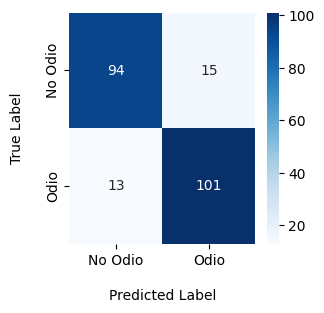

In [ ]:
# plot confusion matrix
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Odio', 'Odio'],
            yticklabels=['No Odio', 'Odio'])
plt.xlabel("\nPredicted Label")
plt.ylabel("True Label\n")
plt.show()

In [ ]:
# to get probabilities
#y_pred_prob = tf.nn.softmax(predictions[0], axis=-1).numpy()

In [ ]:
# Calculate metrics
metrics = {
    "Recall (Macro)": recall_score(y_true, y_pred, average='macro'),
    "Precision (Macro)": precision_score(y_true, y_pred, average='macro'),
    "F1 (Macro)": f1_score(y_true, y_pred, average='macro'),
    "AUC (OvR)": roc_auc_score(y_true, y_pred, multi_class='ovr'),  # One-vs-Rest AUC
    "Accuracy": accuracy_score(y_true, y_pred)
}

# For per-class metrics
per_class_metrics = {
    "Recall (Per Class)": recall_score(y_true, y_pred, average=None),
    "Precision (Per Class)": precision_score(y_true, y_pred, average=None),
    "F1 (Per Class)": f1_score(y_true, y_pred, average=None)
}

# Print results
print("Aggregate Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\nPer-Class Metrics:")
for i, (rec, prec, f1) in enumerate(zip(per_class_metrics["Recall (Per Class)"],
                                      per_class_metrics["Precision (Per Class)"],
                                      per_class_metrics["F1 (Per Class)"])):
    print(f"Class {i}: Recall={rec:.4f}, Precision={prec:.4f}, F1={f1:.4f}")

print(classification_report(y_true, y_pred))

Aggregate Metrics:
Recall (Macro): 0.8742
Precision (Macro): 0.8746
F1 (Macro): 0.8743
AUC (OvR): 0.8742
Accuracy: 0.8744

Per-Class Metrics:
Class 0: Recall=0.8624, Precision=0.8785, F1=0.8704
Class 1: Recall=0.8860, Precision=0.8707, F1=0.8783
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       109
           1       0.87      0.89      0.88       114

    accuracy                           0.87       223
   macro avg       0.87      0.87      0.87       223
weighted avg       0.87      0.87      0.87       223



# Train Hatemedia Data

## Read data

In [ ]:
# load data
df_on = pd.read_csv('/content/drive/MyDrive/HateMedia/Data/Procesada/Odio - No odio/df_odio_no_odio.csv')

# drop na values
df_on = df_on.dropna()

# reset index
df_on = df_on.reset_index(drop=True)

# set labels: 1 = odio, 0 = no odio
df_on['label'] = df_on['label'].apply(lambda x: 1 if x == 'odio' else 0)

# manually update some wrong samples
df_on.loc[df_on['text'].str.contains('maldito hijo de puta'),'label'] = 1
df_on

,text,label
0,s un musulmán negro vinculado al nacimiento de...,0
1,@usuario esto va de casta oscuro ya,0
2,con todos los problemas que tenemos en el sigl...,0
3,fiscaly de los rojos y las dem aplaudiendo y t...,0
4,Vamos a aclarar que qc en uk 4 meses de prisin...,0
...,...,...
1900087,actualizacin el hombre adems tena una orden de...,0
1900088,@usuario ah est la justicia blandenguela ju...,1
1900089,@usuario si al morito asesino lo hubieran entr...,0
1900090,@usuario @usuario @usuario pues con 4000 al añ...,1


In [ ]:
# see class distribution
df_on['label'].value_counts()

,count
label,
1,1003638
0,896454


In [ ]:
# Split your DataFrame
train_df, temp_df = train_test_split(df_on, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# convert to tensorflow, tokenize and create datasets in trainable format
num_labels = len(df_on['label'].unique())
train_dataset = preprocess_data(train_df,num_labels)
test_dataset = preprocess_data(test_df,num_labels)
val_dataset = preprocess_data(val_df,num_labels)


## Train

In [ ]:
# Calculate training parameters
batch_size = 128
epochs = 5
steps_per_epoch = len(train_df) // batch_size
total_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * total_steps)  # 10% warmup
total_steps,warmup_steps

# Initialize optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=WarmupLinearSchedule(
        warmup_steps=warmup_steps,
        max_lr=2e-5))

# Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=2,
    verbose=1)

In [ ]:
# Compile model
classification_model.compile(
    optimizer=optimizer,  # Pass the optimizer instance directly
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.Recall(name='recall', class_id=0), # Focus on NO hate class
             tf.keras.metrics.Precision(name='precision', class_id=1), # Focus on hate class
             tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'), # Focus on hate class
             tf.keras.metrics.F1Score(name="f1_score", average='weighted'), # Use weighted average for f1_score
             tf.keras.metrics.AUC(name='AUC', curve='PR'),
             tf.keras.metrics.RecallAtPrecision(precision=0.9, name='recall_at_precision', class_id=0), # Focus on NO hate class
             tf.keras.metrics.PrecisionAtRecall(recall=0.9, class_id=1)]) # Focus on hate class



# Train model
history = classification_model.fit(
    train_dataset.batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    callbacks=callback,
    batch_size=batch_size,
    epochs=epochs)

Epoch 1/5
11876/11876 [==============================] - 3967s 330ms/step - loss: 0.2570 - recall: 0.7660 - precision: 0.9233 - binary_accuracy: 0.8834 - f1_score: 0.9004 - AUC: 0.9212 - recall_at_precision: 0.8743 - precision_at_recall: 0.9076 - val_loss: 0.1711 - val_recall: 0.9010 - val_precision: 0.9478 - val_binary_accuracy: 0.9412 - val_f1_score: 0.9452 - val_AUC: 0.9491 - val_recall_at_precision: 0.9288 - val_precision_at_recall: 0.9520
Epoch 2/5
11876/11876 [==============================] - 3919s 330ms/step - loss: 0.2272 - recall: 0.8121 - precision: 0.9406 - binary_accuracy: 0.9040 - f1_score: 0.9182 - AUC: 0.9312 - recall_at_precision: 0.8953 - precision_at_recall: 0.9358 - val_loss: 0.1744 - val_recall: 0.8592 - val_precision: 0.9448 - val_binary_accuracy: 0.9336 - val_f1_score: 0.9461 - val_AUC: 0.9475 - val_recall_at_precision: 0.9298 - val_precision_at_recall: 0.9510
Epoch 3/5
11876/11876 [==============================] - 3919s 330ms/step - loss: 0.1657 - recall: 0.861

# Results

In [ ]:
# make predictions
predictions = classification_model.predict(test_dataset.batch(batch_size))

1485/1485 [==============================] - 167s 110ms/step


In [ ]:
# Get true labels from test_df
y_true = test_df['label']

# Get predictions from your model
y_pred = tf.argmax(predictions, axis=1)  # predictions contains probabilities/logits

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

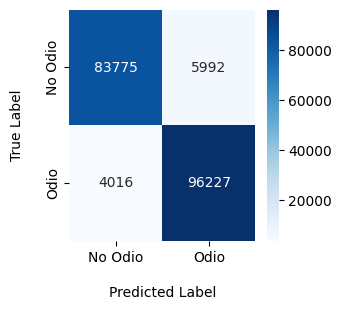

In [ ]:
# plot confusion matrix
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Odio', 'Odio'],
            yticklabels=['No Odio', 'Odio'])
plt.xlabel("\nPredicted Label")
plt.ylabel("True Label\n")
plt.show()

In [ ]:
# Calculate metrics
metrics = {
    "Recall (Macro)": recall_score(y_true, y_pred, average='macro'),
    "Precision (Macro)": precision_score(y_true, y_pred, average='macro'),
    "F1 (Macro)": f1_score(y_true, y_pred, average='macro'),
    "AUC (OvR)": roc_auc_score(y_true, y_pred, multi_class='ovr'),  # One-vs-Rest AUC
    "Accuracy": accuracy_score(y_true, y_pred)
}

# For per-class metrics
per_class_metrics = {
    "Recall (Per Class)": recall_score(y_true, y_pred, average=None),
    "Precision (Per Class)": precision_score(y_true, y_pred, average=None),
    "F1 (Per Class)": f1_score(y_true, y_pred, average=None)
}

# Print results
print("Aggregate Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\nPer-Class Metrics:")
for i, (rec, prec, f1) in enumerate(zip(per_class_metrics["Recall (Per Class)"],
                                      per_class_metrics["Precision (Per Class)"],
                                      per_class_metrics["F1 (Per Class)"])):
    print(f"Class {i}: Recall={rec:.4f}, Precision={prec:.4f}, F1={f1:.4f}")

print(classification_report(y_true, y_pred))

Aggregate Metrics:
Recall (Macro): 0.9466
Precision (Macro): 0.9478
F1 (Macro): 0.9471
AUC (OvR): 0.9466
Accuracy: 0.9473

Per-Class Metrics:
Class 0: Recall=0.9332, Precision=0.9543, F1=0.9436
Class 1: Recall=0.9599, Precision=0.9414, F1=0.9506
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     89767
           1       0.94      0.96      0.95    100243

    accuracy                           0.95    190010
   macro avg       0.95      0.95      0.95    190010
weighted avg       0.95      0.95      0.95    190010



# Save the model

In [ ]:
# Print the model summary
classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1087887   ['input_ids[0][0]',           
 assification (TFRobertaFor  (loss=None, logits=(None,    38         'attention_mask[0][0]']      
 SequenceClassification)     2),                                                              

In [ ]:
# save model history (models metrics while training) to csv file
history_df = pd.DataFrame(history.history)
history_df.to_csv('****.csv')

In [ ]:
# save model weights
classification_model.save_weights("***.h5")

# save tokenizer
tokenizer.save_pretrained("***")

# requirements

In [ ]:
# save requirements as a txt file
!pip freeze > requirements.txt